In [1]:
pip install xgboost==1.7.6

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

# -----------------------------
# 1) 데이터 로드 & 정렬 & 결측 처리
# -----------------------------
df = pd.read_csv('timeseries_data_ccsi2.csv')

# '연월_dt'가 문자열이면 파싱
if not np.issubdtype(pd.Series(df.get('연월_dt')).dtype, np.datetime64):
    if '연월_dt' in df.columns:
        df['연월_dt'] = pd.to_datetime(df['연월_dt'], errors='coerce')
    elif '연월' in df.columns:
        # 예: 202401 형태라면
        df['연월_dt'] = pd.to_datetime(df['연월'].astype(str), format='%Y%m', errors='coerce')
    else:
        raise ValueError("날짜 컬럼(연월 혹은 연월_dt)이 필요합니다.")

df = df.sort_values('연월_dt').reset_index(drop=True)

# 결측치 보간(앞뒤 채우기)
df_model = df.bfill().ffill()

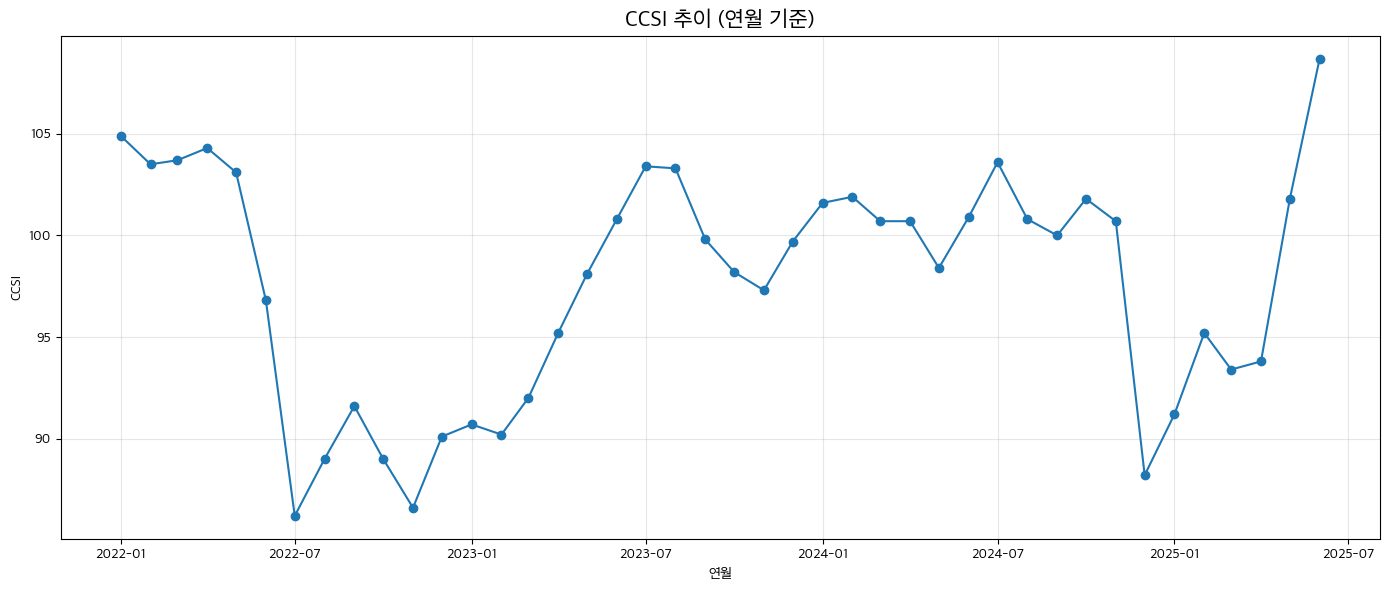

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='Apple SD Gothic Neo')

# 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False

# 연월을 datetime으로 변환
df['연월_dt'] = pd.to_datetime(df['연월'].astype(str), format='%Y%m', errors='coerce')

# 필요한 컬럼만
df_plot = df[['연월_dt', 'CCSI']].dropna().sort_values('연월_dt')

# 시각화
plt.figure(figsize=(14,6))
plt.plot(df_plot['연월_dt'], df_plot['CCSI'], marker='o', linestyle='-')
plt.title("CCSI 추이 (연월 기준)", fontsize=16)
plt.xlabel("연월")
plt.ylabel("CCSI")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# 날짜 컬럼 datetime 변환
df['연월_dt'] = pd.to_datetime(df['연월'].astype(str), format='%Y%m', errors='coerce')

# 초기값 0으로 설정
df['up_month'] = 0
df['down_month'] = 0

# 1) Down month 구간
mask_down = (
    ((df['연월_dt'] >= '2022-07-01') & (df['연월_dt'] <= '2023-04-30')) |
    ((df['연월_dt'] >= '2024-12-01') & (df['연월_dt'] <= '2025-04-30'))
)
df.loc[mask_down, 'down_month'] = 1

# 2) Up month 특정 달
mask_up = (
    (df['연월_dt'] == pd.to_datetime('2022-01-01')) |
    (df['연월_dt'] == pd.to_datetime('2025-06-01'))
)
df.loc[mask_up, 'up_month'] = 1

# 확인
print(df[['연월_dt', 'CCSI', 'up_month', 'down_month']].head(20))

        연월_dt   CCSI  up_month  down_month
0  2022-01-01  104.9         1           0
1  2022-02-01  103.5         0           0
2  2022-03-01  103.7         0           0
3  2022-04-01  104.3         0           0
4  2022-05-01  103.1         0           0
5  2022-06-01   96.8         0           0
6  2022-07-01   86.2         0           1
7  2022-08-01   89.0         0           1
8  2022-09-01   91.6         0           1
9  2022-10-01   89.0         0           1
10 2022-11-01   86.6         0           1
11 2022-12-01   90.1         0           1
12 2023-01-01   90.7         0           1
13 2023-02-01   90.2         0           1
14 2023-03-01   92.0         0           1
15 2023-04-01   95.2         0           1
16 2023-05-01   98.1         0           0
17 2023-06-01  100.8         0           0
18 2023-07-01  103.4         0           0
19 2023-08-01  103.3         0           0


In [5]:


# -----------------------------
# 2) 피처/타깃 분리
# -----------------------------
target_col = 'CCSI'
drop_cols = [target_col, '연월', '연월_dt']
drop_cols = [c for c in drop_cols if c in df_model.columns]

X_all = df_model.drop(columns=drop_cols)
y_all = df_model[target_col]

# 숫자형만 사용(원-핫 안 되어 있는 문자열이 섞여 있으면 학습 불가 방지)
X_all = X_all.select_dtypes(include=[np.number]).copy()

# -----------------------------
# 3) 최종 홀드아웃(최근 6개월) 분리
# -----------------------------
holdout_horizon = 6
split_point = len(X_all) - holdout_horizon
X_train_full, X_holdout = X_all.iloc[:split_point], X_all.iloc[split_point:]
y_train_full, y_holdout = y_all.iloc[:split_point], y_all.iloc[split_point:]

print(f"[Info] 학습 구간: {X_train_full.shape}, 홀드아웃(최근 6개월): {X_holdout.shape}")

# -----------------------------
# 4) TimeSeriesSplit (워크포워드 검증)
#    - 각 폴드의 검증 길이를 6개월로 고정
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5, test_size=6)

fold_metrics = []
best_iterations = []

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train_full), start=1):
    X_tr, X_val = X_train_full.iloc[tr_idx], X_train_full.iloc[val_idx]
    y_tr, y_val = y_train_full.iloc[tr_idx], y_train_full.iloc[val_idx
                                                               ]
    early_stop = EarlyStopping(
    rounds=50,          # 50번 동안 개선 없으면 종료
    save_best=True,     # 최적 모델 저장
    maximize=False      # MAE, RMSE 같은 지표는 작을수록 좋으므로 False
    )

    # ----- XGB 모델(가벼운 베이스라인) -----
    model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    early_stopping_rounds=50,
    )
   
    # ----- early_stopping: 각 폴드의 검증셋을 eval_set으로 사용 -----
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    # 폴드 성능
    y_val_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    r2 = r2_score(y_val, y_val_pred)

    fold_metrics.append({"fold": fold, "MAE": mae, "RMSE": rmse, "R2": r2})
    best_iterations.append(getattr(model, "best_iteration", model.n_estimators))

# 폴드 평균 결과 출력
cv_mae = np.mean([m["MAE"] for m in fold_metrics])
cv_rmse = np.mean([m["RMSE"] for m in fold_metrics])
cv_r2 = np.mean([m["R2"] for m in fold_metrics])
avg_best_iter = int(np.mean(best_iterations))

print("=== TimeSeriesSplit CV 결과(검증 6개월 고정) ===")
for m in fold_metrics:
    print(f"Fold {m['fold']}: MAE={m['MAE']:.3f}, RMSE={m['RMSE']:.3f}, R2={m['R2']:.3f}")
print(f"CV 평균: MAE={cv_mae:.3f}, RMSE={cv_rmse:.3f}, R2={cv_r2:.3f}, 평균 best_iteration={avg_best_iter}")

# -----------------------------
# 5) CV에서 구한 평균 best_iteration으로 전체 학습구간 재학습
#    (홀드아웃은 한 번만 사용)
# -----------------------------
final_model = XGBRegressor(
    n_estimators=max(200, int(avg_best_iter * 1.1)),  # 약간 여유
    learning_rate=0.03,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    early_stopping_rounds=50,
)

# 학습구간 내에서 다시 한 번 early_stopping을 쓰되,
# 마지막 6개월을 내부 검증으로 활용(홀드아웃과는 별개)
inner_val = 6
X_tr2, X_val2 = X_train_full.iloc[:-inner_val], X_train_full.iloc[-inner_val:]
y_tr2, y_val2 = y_train_full.iloc[:-inner_val], y_train_full.iloc[-inner_val:]

final_model.fit(
    X_tr2, y_tr2,
    eval_set=[(X_val2, y_val2)],
    verbose=False,
)

# -----------------------------
# 6) 홀드아웃(최근 6개월) 평가
# -----------------------------
y_pred_holdout = final_model.predict(X_holdout)
mae_h = mean_absolute_error(y_holdout, y_pred_holdout)
rmse_h = mean_squared_error(y_holdout, y_pred_holdout, squared=False)
r2_h = r2_score(y_holdout, y_pred_holdout)

print("\n=== 최종 홀드아웃(최근 6개월) 성능 ===")
print(f"MAE={mae_h:.3f}, RMSE={rmse_h:.3f}, R2={r2_h:.3f}")

[Info] 학습 구간: (36, 21), 홀드아웃(최근 6개월): (6, 21)
=== TimeSeriesSplit CV 결과(검증 6개월 고정) ===
Fold 1: MAE=1.507, RMSE=1.888, R2=-0.009
Fold 2: MAE=4.153, RMSE=5.845, R2=-1.220
Fold 3: MAE=6.182, RMSE=6.647, R2=-7.125
Fold 4: MAE=1.287, RMSE=1.375, R2=-0.497
Fold 5: MAE=2.541, RMSE=3.669, R2=0.471
CV 평균: MAE=3.134, RMSE=3.885, R2=-1.676, 평균 best_iteration=305

=== 최종 홀드아웃(최근 6개월) 성능 ===
MAE=3.840, RMSE=4.762, R2=0.379


--- RandomForest 모델 평가 결과 ---
RMSE (Root Mean Squared Error): 5
MAE (Mean Absolute Error): 4
R² (결정 계수): 0.3794

실제값과 예측값을 비교한 그래프를 'prediction_vs_actual.png' 파일로 저장했습니다.


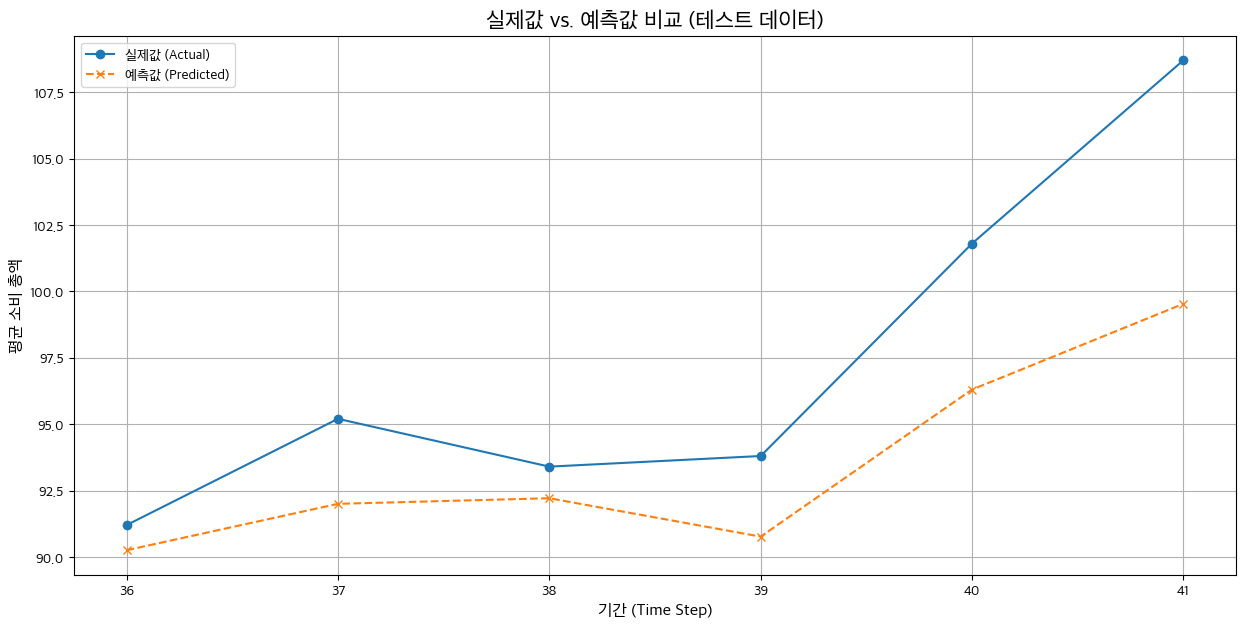

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



# --- 3. 모델 평가 ---

# 학습된 모델을 사용하여 테스트 데이터의 값을 예측합니다.
y_pred = final_model.predict(X_holdout)

# 평가 지표를 계산합니다.
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
mae = mean_absolute_error(y_holdout, y_pred)
r2 = r2_score(y_holdout, y_pred)

print("--- RandomForest 모델 평가 결과 ---")
print(f"RMSE (Root Mean Squared Error): {rmse:,.0f}")
print(f"MAE (Mean Absolute Error): {mae:,.0f}")
print(f"R² (결정 계수): {r2:.4f}")


# --- 4. 결과 시각화 ---

plt.rc('font', family='Apple SD Gothic Neo')

# 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 생성하고 저장합니다.
plt.figure(figsize=(15, 7))
plt.plot(y_holdout.index, y_holdout, label='실제값 (Actual)', marker='o')
plt.plot(y_holdout.index, y_pred, label='예측값 (Predicted)', marker='x', linestyle='--')
plt.title('실제값 vs. 예측값 비교 (테스트 데이터)', fontsize=16)
plt.xlabel('기간 (Time Step)', fontsize=12)
plt.ylabel('평균 소비 총액', fontsize=12)
plt.legend()
plt.grid(True)



=== 전체 구간 성능 (훈련+홀드아웃) ===
RMSE=2.321, MAE=1.202, R2=0.835
참고: 훈련 구간이 포함되어 테스트 단독 지표보다 좋게 보일 수 있습니다.


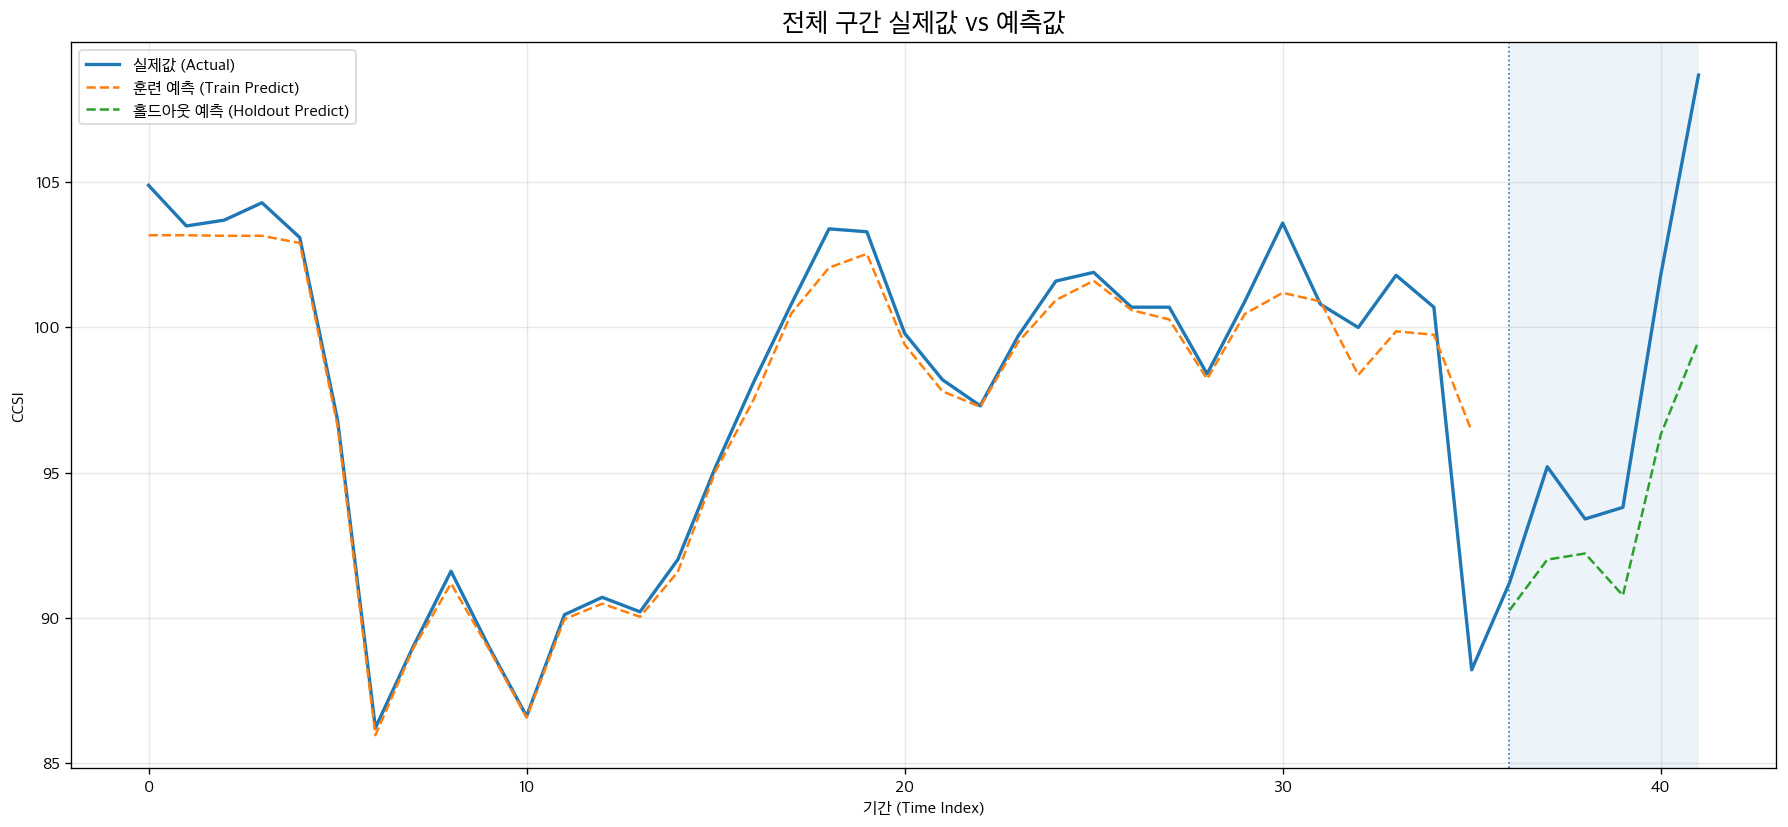

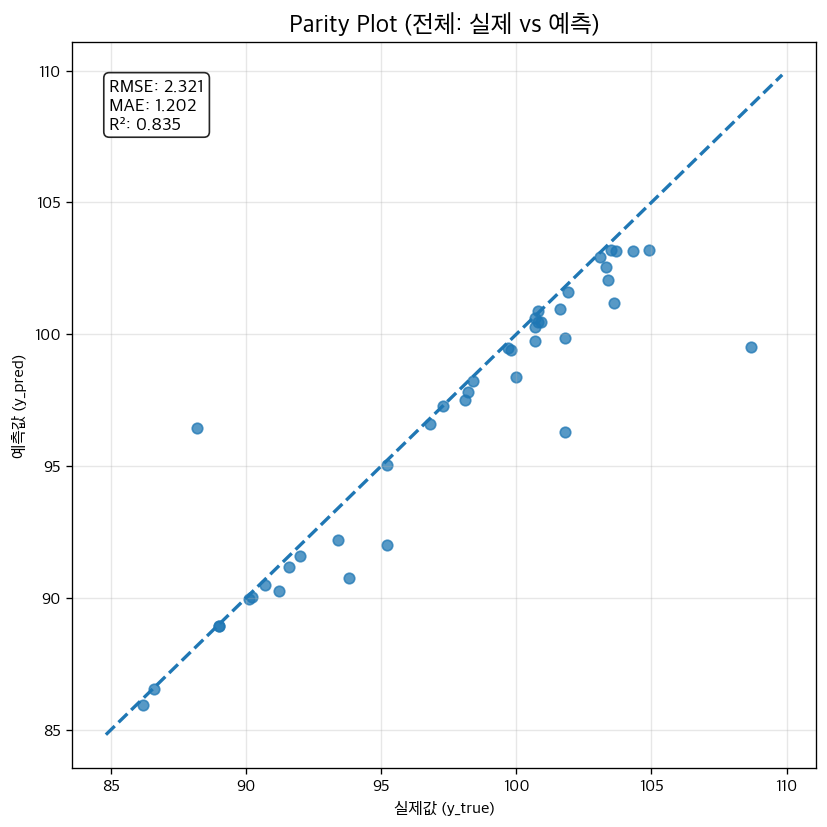

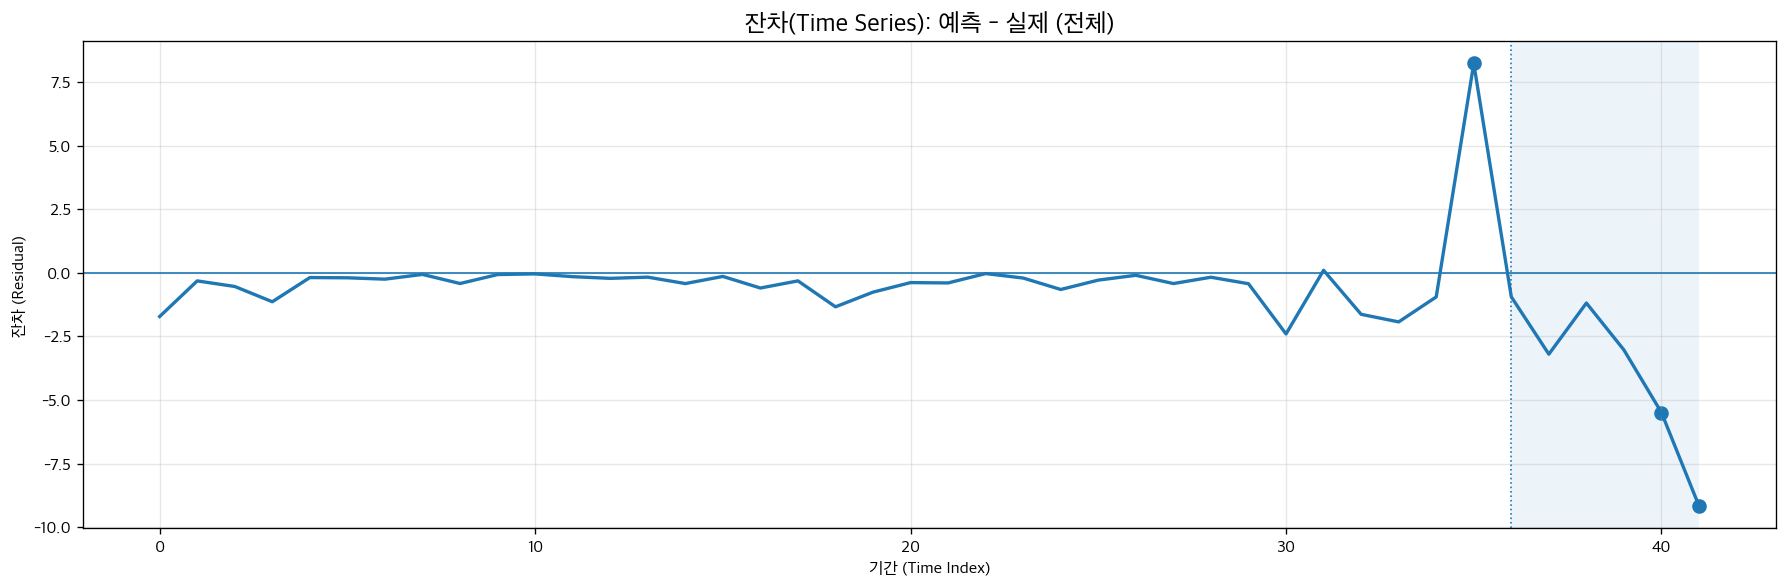

In [7]:
# -----------------------------
# 7) 전체 구간 결과 생성 (훈련 + 홀드아웃)
# -----------------------------
import os
import matplotlib.pyplot as plt

# 안전: 인덱스 정렬
y_train_full = y_train_full.sort_index()
y_holdout    = y_holdout.sort_index()

# 훈련/홀드아웃 예측
y_pred_train_full = final_model.predict(X_train_full)
y_pred_holdout    = final_model.predict(X_holdout)

# 시리즈로 변환해 인덱스 정합 보장
y_pred_train_s = pd.Series(y_pred_train_full, index=y_train_full.index, name="y_pred")
y_pred_hold_s  = pd.Series(y_pred_holdout,    index=y_holdout.index,    name="y_pred")

# 전체 실제/예측 시리즈
y_full_actual = pd.concat([y_train_full, y_holdout])
y_full_pred   = pd.concat([y_pred_train_s, y_pred_hold_s]).loc[y_full_actual.index]

# -----------------------------
# 8) 전체 구간 평가
# -----------------------------
rmse_full = np.sqrt(mean_squared_error(y_full_actual.values, y_full_pred.values))
mae_full  = mean_absolute_error(y_full_actual.values, y_full_pred.values)
r2_full   = r2_score(y_full_actual.values, y_full_pred.values)

print("\n=== 전체 구간 성능 (훈련+홀드아웃) ===")
print(f"RMSE={rmse_full:,.3f}, MAE={mae_full:,.3f}, R2={r2_full:.3f}")
print("참고: 훈련 구간이 포함되어 테스트 단독 지표보다 좋게 보일 수 있습니다.")

# -----------------------------
# 9) 전체 구간 시각화 (라인 / 파리티 / 잔차)
# -----------------------------
os.makedirs("figs", exist_ok=True)

# (옵션) 한글 폰트 / 마이너스 설정
try:
    plt.rc('font', family='Apple SD Gothic Neo')
except Exception:
    pass
plt.rcParams['axes.unicode_minus'] = False

# 9-1) 전체 라인 플롯
plt.figure(figsize=(15, 7), dpi=120)
plt.plot(y_full_actual.index, y_full_actual.values, label='실제값 (Actual)', linewidth=2)
plt.plot(y_train_full.index,  y_pred_train_s.values, label='훈련 예측 (Train Predict)', linestyle='--')
plt.plot(y_holdout.index,     y_pred_hold_s.values,  label='홀드아웃 예측 (Holdout Predict)', linestyle='--')

# 훈련/홀드아웃 경계선 & 음영
try:
    boundary_x = y_holdout.index.min()
    plt.axvline(boundary_x, linestyle=':', linewidth=1)
    plt.axvspan(boundary_x, y_holdout.index.max(), alpha=0.08)  # 홀드아웃 영역 음영
except Exception:
    pass

plt.title('전체 구간 실제값 vs 예측값', fontsize=16)
plt.xlabel('기간 (Time Index)')
plt.ylabel(target_col)  # 'CCSI'
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 9-2) Parity Plot (y_true vs y_pred)
ymin = float(min(y_full_actual.min(), y_full_pred.min()))
ymax = float(max(y_full_actual.max(), y_full_pred.max()))
pad  = 0.05 * (ymax - ymin + 1e-9)

plt.figure(figsize=(7, 7), dpi=120)
plt.scatter(y_full_actual.values, y_full_pred.values, s=40, alpha=0.75)
plt.plot([ymin - pad, ymax + pad], [ymin - pad, ymax + pad], linestyle='--', linewidth=2)
plt.title('Parity Plot (전체: 실제 vs 예측)', fontsize=15)
plt.xlabel('실제값 (y_true)')
plt.ylabel('예측값 (y_pred)')
text_str = f"RMSE: {rmse_full:,.3f}\nMAE: {mae_full:,.3f}\nR²: {r2_full:.3f}"
plt.gca().text(0.05, 0.95, text_str, transform=plt.gca().transAxes,
               fontsize=11, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 9-3) 잔차 플롯 (전체)
residual = y_full_pred - y_full_actual
res_std  = residual.std()
outlier_mask = residual.abs() > 2 * res_std

plt.figure(figsize=(15, 5), dpi=120)
plt.axhline(0, linewidth=1)
plt.plot(y_full_actual.index, residual.values, linewidth=2)
plt.scatter(residual.index[outlier_mask], residual[outlier_mask], s=60)
try:
    boundary_x = y_holdout.index.min()
    plt.axvline(boundary_x, linestyle=':', linewidth=1)
    plt.axvspan(boundary_x, y_holdout.index.max(), alpha=0.08)
except Exception:
    pass
plt.title('잔차(Time Series): 예측 - 실제 (전체)', fontsize=15)
plt.xlabel('기간 (Time Index)')
plt.ylabel('잔차 (Residual)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [10]:
# -----------------------------
# 10) 예측 결과 CSV 저장
# -----------------------------
result_df = pd.DataFrame({
    "y_true": y_full_actual.values,
    "y_pred": y_full_pred.values
}, index=y_full_actual.index)

# 인덱스가 날짜/기간이라면 컬럼으로 저장
result_df = result_df.reset_index().rename(columns={"index": "time"})

# -----------------------------
# 10) 예측 결과 CSV 저장 (time = 2022-01 ~ 2025-06)
# -----------------------------
# 전체 구간 길이
n = len(y_full_actual)

# 2022-01부터 1개월 단위로 생성
time_index = pd.date_range("2022-01", "2025-06", freq="MS")

# 혹시 길이가 다를 경우, 앞에서부터 n개만 맞춤
if len(time_index) > n:
    time_index = time_index[:n]
elif len(time_index) < n:
    raise ValueError("time index 길이가 실제 데이터 길이보다 짧습니다.")

# 결과 DataFrame 생성
result_df = pd.DataFrame({
    "time": time_index.strftime("%Y-%m"),  # YYYY-MM 포맷
    "y_true": y_full_actual.values,
    "y_pred": y_full_pred.values
})

os.makedirs("results", exist_ok=True)
out_path = "results/ccsi_prediction_vs_actual.csv"
result_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"✅ 예측 결과 저장 완료: {out_path}")
print(result_df.head())

✅ 예측 결과 저장 완료: results/ccsi_prediction_vs_actual.csv
      time  y_true      y_pred
0  2022-01   104.9  103.179901
1  2022-02   103.5  103.179901
2  2022-03   103.7  103.160805
3  2022-04   104.3  103.160805
4  2022-05   103.1  102.911674



--- 모델 특성 중요도 (Feature Importances) ---
             feature  importance
1         CCSI_lag_1    0.334407
10  CCSI_roll_mean_6    0.138302
19      CCSI_slope_3    0.085396
11   CCSI_roll_std_6    0.071707
5         CCSI_lag_3    0.071084
12     총액_roll_max_6    0.064103
9      총액_roll_std_6    0.063571
3         CCSI_lag_2    0.038564
15       CCSI_diff_1    0.036281
2           총액_lag_2    0.022831
6          총액_lag_12    0.017647
20             month    0.012723
0           총액_lag_1    0.011753
4           총액_lag_3    0.007914
16        총액_diff_12    0.006233
17      CCSI_diff_12    0.005755
7        CCSI_lag_12    0.004915
8     총액_roll_mean_6    0.002928
18        총액_slope_3    0.002203
14         총액_diff_1    0.001684
13     총액_roll_min_6    0.000000


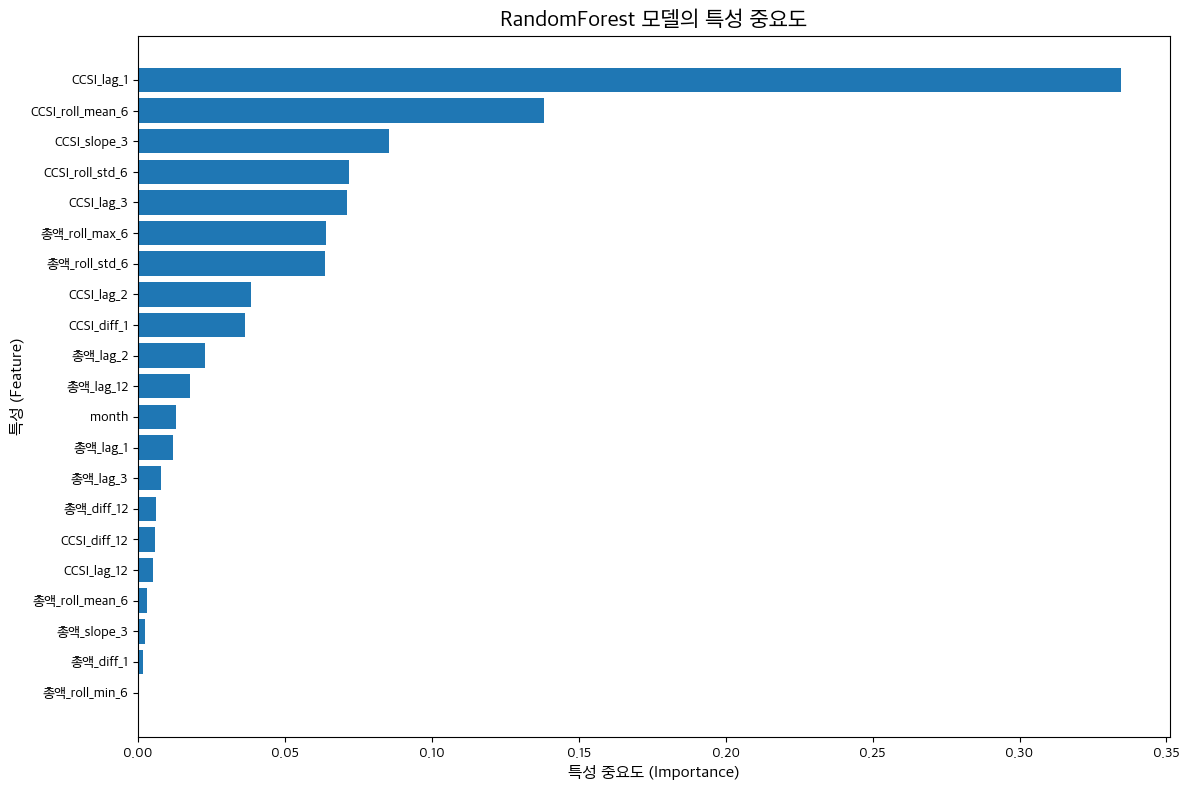

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', family='Apple SD Gothic Neo')

# 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False



# --- 특성 중요도 추정 및 시각화 ---
# (이 코드를 실행하기 전에 model 객체와 X_train_full 데이터프레임이 미리 정의되어 있어야 합니다)

# 특성 중요도 추출
importances = model.feature_importances_

# 특성 이름과 중요도를 짝지어 데이터프레임 생성
feature_importances = pd.DataFrame({'feature': X_train_full.columns, 'importance': importances})

# 중요도 기준으로 내림차순 정렬
feature_importances = feature_importances.sort_values('importance', ascending=False)

# 중요도 결과 출력
print("\n--- 모델 특성 중요도 (Feature Importances) ---")
print(feature_importances)


# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('특성 중요도 (Importance)', fontsize=12)
plt.ylabel('특성 (Feature)', fontsize=12)
plt.title('RandomForest 모델의 특성 중요도', fontsize=16)
plt.gca().invert_yaxis() # 중요도가 높은 특성을 위로 오게 정렬
plt.tight_layout() # 그래프 레이아웃 최적화
plt.show()